# Doublet identification in Multiome-RNA (adult) dataset using _scrublet_ 

In [1]:
# import numpy as np
# import pandas as pd
# import scanpy as sc
# import scrublet as scr
import matplotlib.pyplot as plt
# import scipy.sparse as sp

# import tables
# from typing import Dict
# from fastprogress.fastprogress import  progress_bar

from scanpy import logging as logg
from scanpy.neighbors import neighbors
from anndata import AnnData
from scipy.sparse import csc_matrix

from utils import *

In [2]:
sc.settings.verbosity = 3
sc.logging.print_version_and_date()
sc.settings.set_figure_params(dpi = 160, color_map = 'RdPu', dpi_save = 180, vector_friendly = True, format = 'svg')

Running Scanpy 1.8.1, on 2021-10-20 13:08.


## Create AnnData objects

In [29]:
metadata = pd.read_csv('/nfs/team205/heart/metadata/multiome_metadata_6reg_plus_SAN.csv', sep = ',', index_col = 0)
metadata = metadata[metadata['Protocol'] == 'RNA'].copy()

# metadata.drop(['Target', 'cellranger_outs'], axis=1, inplace=True)

In [30]:
# path = '/nfs/team205/heart/soupremoved/cellbender020/'
# adatas = [anndata_from_h5(path + sample_id + '/' + sample_id + '_cellbender_out_filtered.h5', analyzed_barcodes_only=False) for sample_id in SangerID_RNA]

all_paths = metadata['cellbender_out']
adatas = [anndata_from_h5(path + '/' + path.split("/")[6] + '_cellbender_out_filtered.h5', analyzed_barcodes_only=False) for path in all_paths]

In [5]:
adatas[0].obs

,latent_RT_efficiency,latent_cell_probability,latent_scale
barcode,,,
ATAGATGCAGCAATAA-1,4.540781,0.999999,26579.103516
TTCCTTCTCTGTTCAT-1,4.169046,0.999991,14592.354492
AATTAGGCAGCAATAA-1,3.900294,0.999985,11851.831055
AACCCGCAGCATCCAG-1,3.648930,0.999996,12164.401367
ATAATGGCAATTGCGC-1,3.262726,0.999996,11592.286133
...,...,...,...
GTACGTAGTTGTCATC-1,0.526763,0.594858,4180.775879
CATAATGTCTCACTCA-1,0.423123,0.522917,5243.722656
CCTGATGAGTGGACAA-1,0.452777,0.806682,4544.355957


In [6]:
for i in range(len(adatas)):
    adatas[i].var_names_make_unique()
    adatas[i].obs['sample_id'] = metadata.index[i]
    adatas[i].obs.index = metadata.index[i] + '_' + adatas[i].obs.index 
    for col in metadata.columns:
        adatas[i].obs[col] = metadata[col][i]

adata = adatas[0].concatenate(adatas[1:], index_unique = None)
adata.shape

(148686, 36601)

In [7]:
np.shape(metadata)

(16, 10)

In [8]:
adata.obs.index

Index(['HCAHeartST10773165_HCAHeartST10781062_ATAGATGCAGCAATAA-1',
       'HCAHeartST10773165_HCAHeartST10781062_TTCCTTCTCTGTTCAT-1',
       'HCAHeartST10773165_HCAHeartST10781062_AATTAGGCAGCAATAA-1',
       'HCAHeartST10773165_HCAHeartST10781062_AACCCGCAGCATCCAG-1',
       'HCAHeartST10773165_HCAHeartST10781062_ATAATGGCAATTGCGC-1',
       'HCAHeartST10773165_HCAHeartST10781062_GGGTCACTCATGCCTC-1',
       'HCAHeartST10773165_HCAHeartST10781062_ACTTACAAGCGATAGA-1',
       'HCAHeartST10773165_HCAHeartST10781062_TCCTCACAGACAGGTA-1',
       'HCAHeartST10773165_HCAHeartST10781062_GCATTGCCAATTGAAG-1',
       'HCAHeartST10773165_HCAHeartST10781062_TTATGACCAATTTAGC-1',
       ...
       'HCAHeart9845436_HCAHeart9917178_GCTAGCCAGTGAGGTA-1',
       'HCAHeart9845436_HCAHeart9917178_GCCTCGACACCTACGG-1',
       'HCAHeart9845436_HCAHeart9917178_ACTAACGGTCAGGAAG-1',
       'HCAHeart9845436_HCAHeart9917178_ATTTAGGTCGAAGTAG-1',
       'HCAHeart9845436_HCAHeart9917178_ATGGTTATCGCTAGCA-1',
       'HCAHea

In [9]:
adata.obs['n_counts'] = adata.X.sum(axis = 1)
adata.obs['n_counts'].describe()

count    148686.000000
mean       6913.953125
std       12446.684570
min           0.000000
25%        1211.000000
50%        3373.000000
75%        8089.750000
max      463580.000000
Name: n_counts, dtype: float64

In [10]:
adata.obs

,latent_RT_efficiency,latent_cell_probability,latent_scale,sample_id,SangerID,Foetal_or_Adult,Protocol,Donor,Region_Fine,Region_Coarse,Gender,Age,Type,cellbender_out,batch,n_counts
barcode,,,,,,,,,,,,,,,,
HCAHeartST10773165_HCAHeartST10781062_ATAGATGCAGCAATAA-1,4.540781,0.999999,26579.103516,HCAHeartST10773165_HCAHeartST10781062,HCAHeartST10773165,Adult,RNA,AH1,LV FW ANTLAT EPI,LV,Female,45-50,DCD,/nfs/team205/heart/soupremoved/cellbender020/H...,0,146790.0
HCAHeartST10773165_HCAHeartST10781062_TTCCTTCTCTGTTCAT-1,4.169046,0.999991,14592.354492,HCAHeartST10773165_HCAHeartST10781062,HCAHeartST10773165,Adult,RNA,AH1,LV FW ANTLAT EPI,LV,Female,45-50,DCD,/nfs/team205/heart/soupremoved/cellbender020/H...,0,79284.0
HCAHeartST10773165_HCAHeartST10781062_AATTAGGCAGCAATAA-1,3.900294,0.999985,11851.831055,HCAHeartST10773165_HCAHeartST10781062,HCAHeartST10773165,Adult,RNA,AH1,LV FW ANTLAT EPI,LV,Female,45-50,DCD,/nfs/team205/heart/soupremoved/cellbender020/H...,0,60841.0
HCAHeartST10773165_HCAHeartST10781062_AACCCGCAGCATCCAG-1,3.648930,0.999996,12164.401367,HCAHeartST10773165_HCAHeartST10781062,HCAHeartST10773165,Adult,RNA,AH1,LV FW ANTLAT EPI,LV,Female,45-50,DCD,/nfs/team205/heart/soupremoved/cellbender020/H...,0,55045.0
HCAHeartST10773165_HCAHeartST10781062_ATAATGGCAATTGCGC-1,3.262726,0.999996,11592.286133,HCAHeartST10773165_HCAHeartST10781062,HCAHeartST10773165,Adult,RNA,AH1,LV FW ANTLAT EPI,LV,Female,45-50,DCD,/nfs/team205/heart/soupremoved/cellbender020/H...,0,48754.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HCAHeart9845436_HCAHeart9917178_GATAACGAGGTTAGCT-1,0.413214,0.895106,5144.055664,HCAHeart9845436_HCAHeart9917178,HCAHeart9845436,Adult,RNA,D8,NaN,RA,Male,45-50,DCD,/nfs/team205/heart/soupremoved/cellbender020/H...,15,290.0
HCAHeart9845436_HCAHeart9917178_AGGATGTCAATTTGGT-1,0.715349,0.681196,4341.141602,HCAHeart9845436_HCAHeart9917178,HCAHeart9845436,Adult,RNA,D8,NaN,RA,Male,45-50,DCD,/nfs/team205/heart/soupremoved/cellbender020/H...,15,263.0
HCAHeart9845436_HCAHeart9917178_ACTTATGAGAATCGCT-1,0.775902,0.733225,5095.518066,HCAHeart9845436_HCAHeart9917178,HCAHeart9845436,Adult,RNA,D8,NaN,RA,Male,45-50,DCD,/nfs/team205/heart/soupremoved/cellbender020/H...,15,266.0


## Remove cells with less than 200 genes

In [11]:
sc.pp.filter_cells(adata, min_genes=200)
# sc.pp.filter_genes(adata, min_cells=3)

filtered out 16540 cells that have less than 200 genes expressed


/home/jovyan/my-conda-envs/heart/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [12]:
adata.shape

(132146, 36601)

## Compute QC stats

In [13]:
mito_cells = adata.var_names.str.startswith('MT-')
ribo_cells = adata.var_names.str.startswith('RPS','RPL')
adata.obs['percent_mito'] = np.sum(adata[:, mito_cells].X, axis = 1) / np.sum(adata.X, axis = 1)
adata.obs['percent_ribo'] = np.sum(adata[:, ribo_cells].X, axis = 1) / np.sum(adata.X, axis = 1)

# sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito', 'percent_ribo'], jitter = 0.2, multi_panel = True)
# for qc_metric in ['n_genes', 'n_counts', 'percent_mito', 'percent_ribo']:
#     sc.pl.violin(adata, qc_metric, jitter = 0.2)

... storing 'sample_id' as categorical
... storing 'SangerID' as categorical
... storing 'Foetal_or_Adult' as categorical
... storing 'Protocol' as categorical
... storing 'Donor' as categorical
... storing 'Region_Fine' as categorical
... storing 'Region_Coarse' as categorical
... storing 'Gender' as categorical
... storing 'Age' as categorical
... storing 'Type' as categorical
... storing 'cellbender_out' as categorical
... storing 'feature_type' as categorical


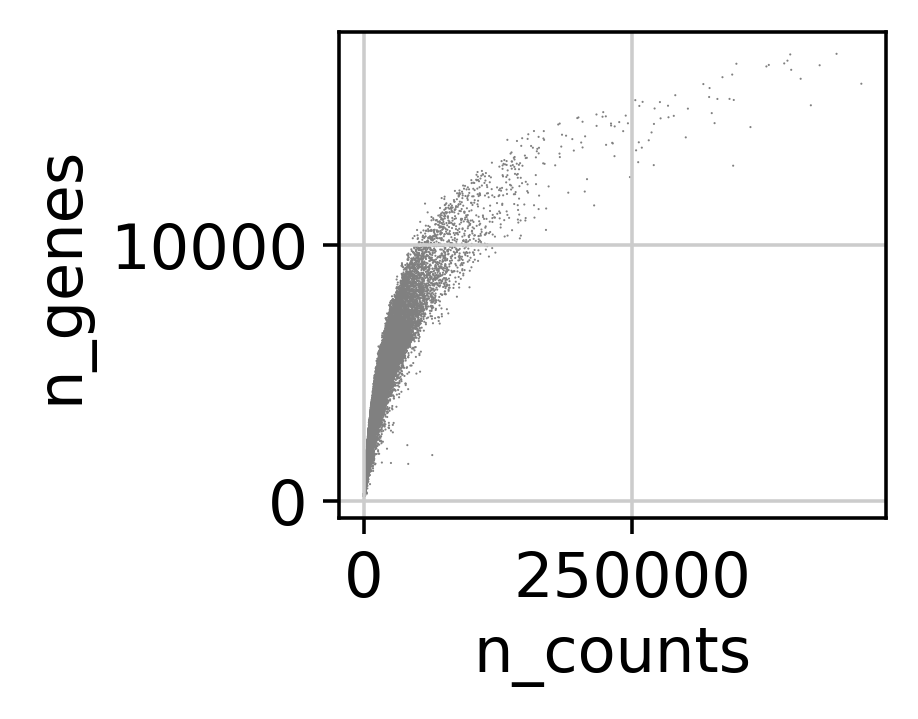

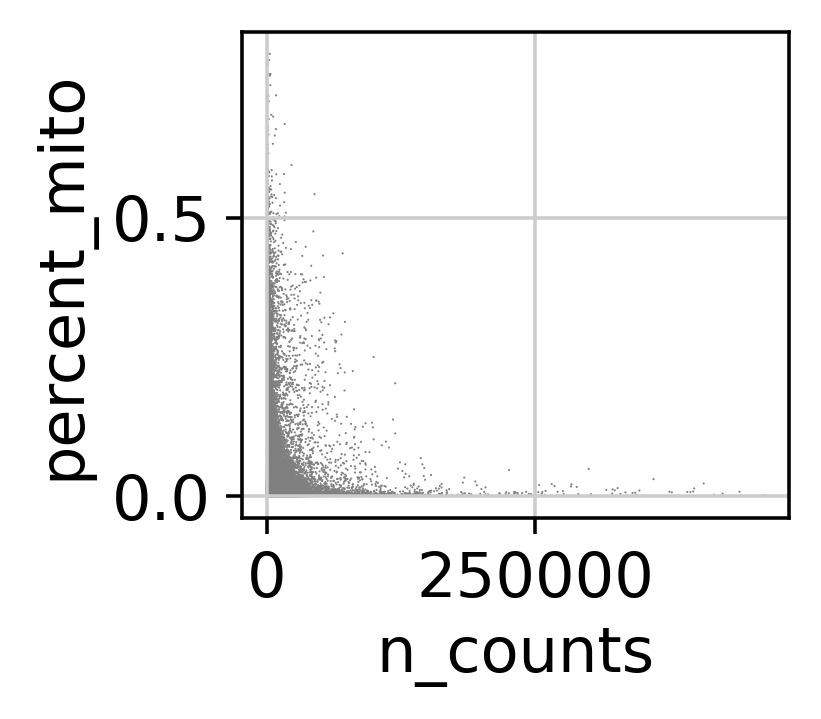

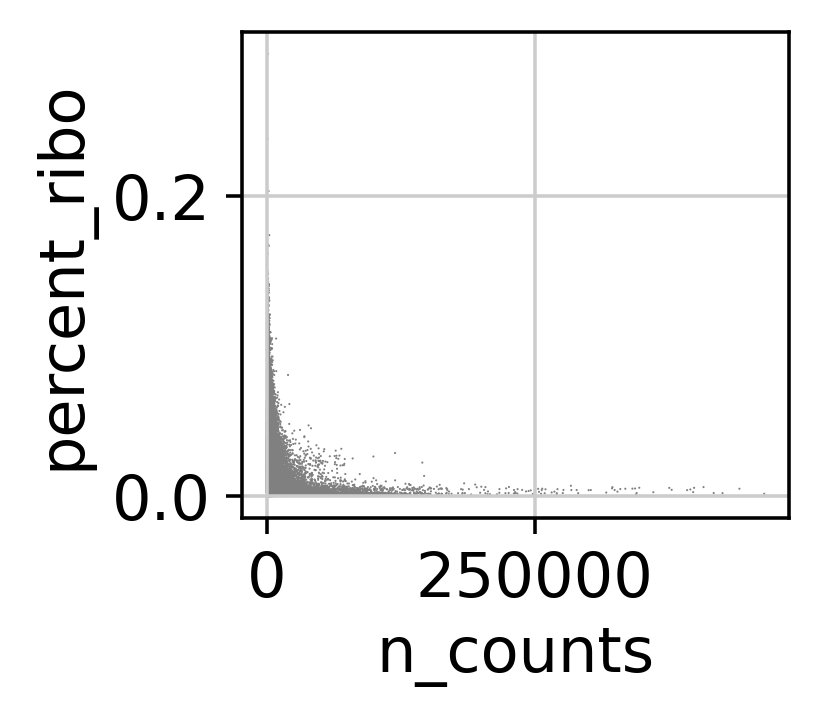

In [14]:
plt.rcParams['figure.figsize'] = [3, 2]

sc.pl.scatter(adata, x='n_counts', y='n_genes')
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='percent_ribo')

## Remove cells exceeding the ribo/mito threshold

/home/jovyan/my-conda-envs/heart/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jovyan/my-conda-envs/heart/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


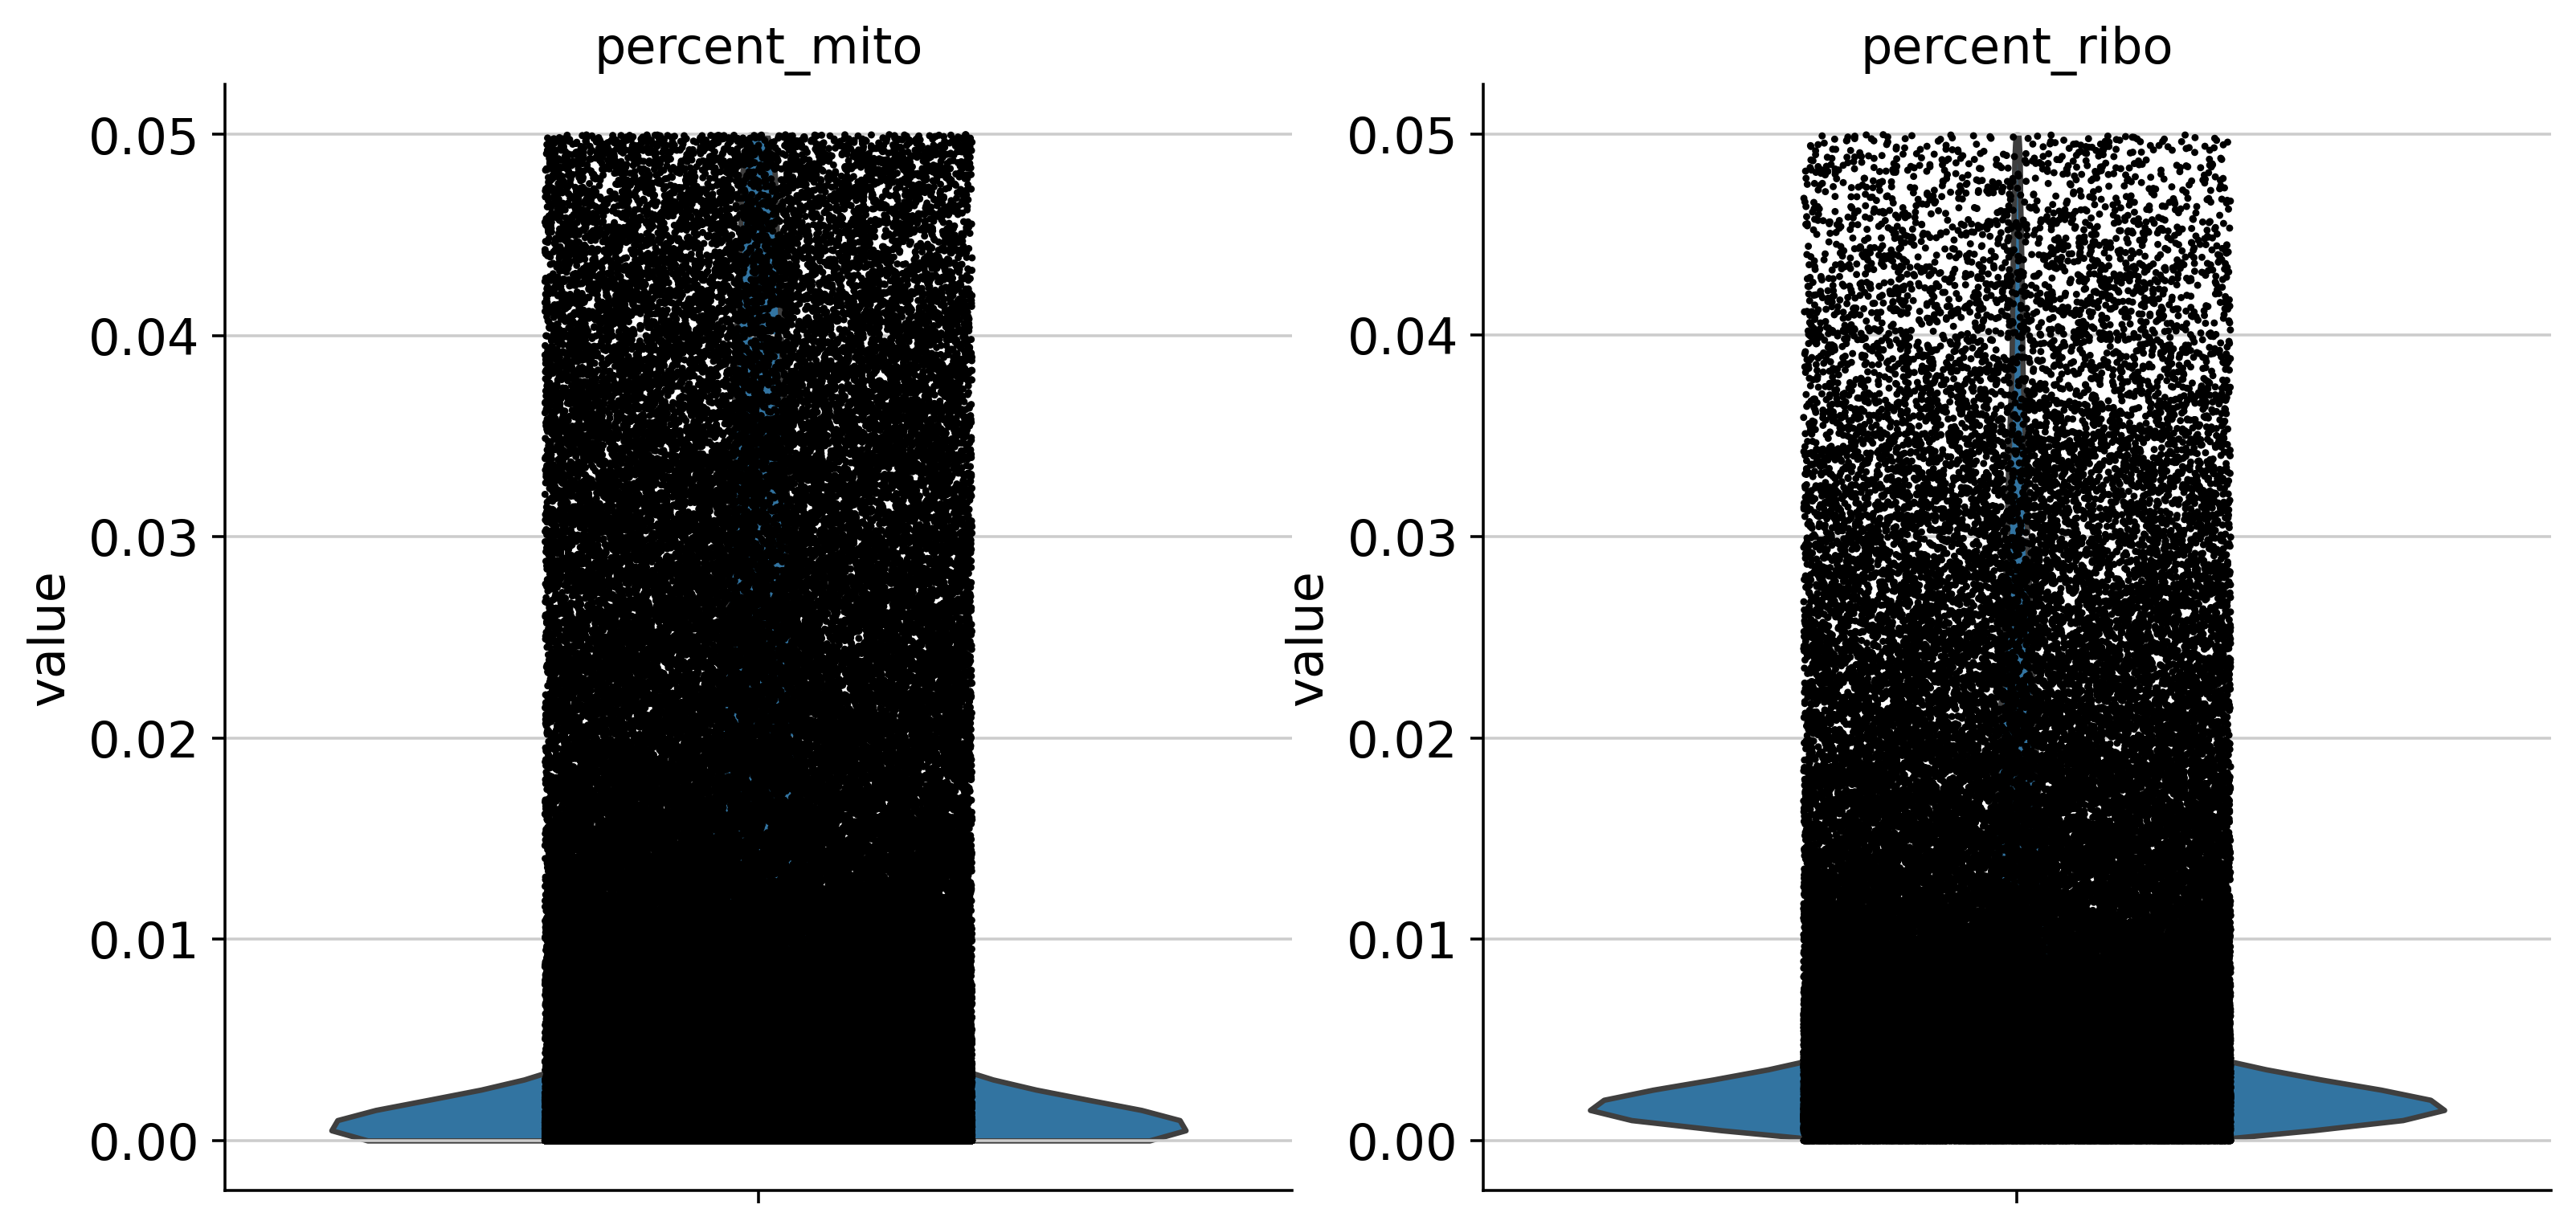

In [15]:
plt.rcParams['figure.figsize'] = [2, 2]
adata = adata[adata.obs['percent_mito'] < 0.05, :]
adata = adata[adata.obs['percent_ribo'] < 0.05, :]
sc.pl.violin(adata, ['percent_mito', 'percent_ribo'],jitter = 0.2, multi_panel = True, size=2)

In [16]:
adata.shape

(107864, 36601)

In [17]:
adata_backup = adata.copy()

In [18]:
np.shape(metadata)

(16, 10)

In [19]:
for i in range(len(metadata.index)):
    ad = adata[adata.obs.sample_id == metadata.index[i],:].copy()
    run_scrublet(ad)
    if i==0:
        meta = ad.obs
    else:
        meta = pd.concat([meta, ad.obs])
    del ad

/home/jovyan/my-conda-envs/heart/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jovyan/my-conda-envs/heart/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jovyan/my-conda-envs/heart/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jovyan/my-conda-envs/heart/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_ca

In [20]:
meta_scrub = meta.loc[:,['scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval']].copy()

In [21]:
meta.index

Index(['HCAHeartST10773165_HCAHeartST10781062_TTCCTTCTCTGTTCAT-1',
       'HCAHeartST10773165_HCAHeartST10781062_AATTAGGCAGCAATAA-1',
       'HCAHeartST10773165_HCAHeartST10781062_AACCCGCAGCATCCAG-1',
       'HCAHeartST10773165_HCAHeartST10781062_ATAATGGCAATTGCGC-1',
       'HCAHeartST10773165_HCAHeartST10781062_GGGTCACTCATGCCTC-1',
       'HCAHeartST10773165_HCAHeartST10781062_ACTTACAAGCGATAGA-1',
       'HCAHeartST10773165_HCAHeartST10781062_TCCTCACAGACAGGTA-1',
       'HCAHeartST10773165_HCAHeartST10781062_GCATTGCCAATTGAAG-1',
       'HCAHeartST10773165_HCAHeartST10781062_TTATGACCAATTTAGC-1',
       'HCAHeartST10773165_HCAHeartST10781062_AGCTAAACAATAGCAA-1',
       ...
       'HCAHeart9845436_HCAHeart9917178_AGTACGCGTCATAAGT-1',
       'HCAHeart9845436_HCAHeart9917178_TCATCCATCTACCTGC-1',
       'HCAHeart9845436_HCAHeart9917178_AGTTGGCGTCCACAAA-1',
       'HCAHeart9845436_HCAHeart9917178_CATGCAAGTCACTCGC-1',
       'HCAHeart9845436_HCAHeart9917178_ATGTCATCAGTCTATG-1',
       'HCAHea

In [25]:
np.shape(meta)

(107864, 24)

In [23]:
adata

View of AnnData object with n_obs × n_vars = 107864 × 36601
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'sample_id', 'SangerID', 'Foetal_or_Adult', 'Protocol', 'Donor', 'Region_Fine', 'Region_Coarse', 'Gender', 'Age', 'Type', 'cellbender_out', 'batch', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo'
    var: 'feature_type', 'id', 'ambient_expression-0', 'ambient_expression-1', 'ambient_expression-10', 'ambient_expression-11', 'ambient_expression-12', 'ambient_expression-13', 'ambient_expression-14', 'ambient_expression-15', 'ambient_expression-2', 'ambient_expression-3', 'ambient_expression-4', 'ambient_expression-5', 'ambient_expression-6', 'ambient_expression-7', 'ambient_expression-8', 'ambient_expression-9'
    obsm: 'latent_gene_encoding'

In [26]:
if meta.index.equals(adata.obs.index):
    adata.obs = pd.concat([adata.obs, meta_scrub], axis=1)
else:
    raise Exception('Different barcodes in meta and adata')

In [27]:
adata.write('/nfs/team205/heart/anndata_objects/multiome_RNA_adult_with_SAN.h5ad')

... storing 'scrublet_leiden' as categorical


In [28]:
adata.obs.index[:3]

Index(['HCAHeartST10773165_HCAHeartST10781062_TTCCTTCTCTGTTCAT-1',
       'HCAHeartST10773165_HCAHeartST10781062_AATTAGGCAGCAATAA-1',
       'HCAHeartST10773165_HCAHeartST10781062_AACCCGCAGCATCCAG-1'],
      dtype='object', name='barcode')